In [ ]:
!pip install pythtb
!pip install BerryEasy
!pip install pybinding

In [ ]:
from __future__ import print_function
from pythtb import * # import TB model class
import numpy as np
import matplotlib.pyplot as plt
import pybinding as pb
from BerryEasy import BerryEasy as be
from BerryEasy import BerryEasyGPU as begpu
import cupy as cp

In [ ]:
# Begin by defining the Chern insulator model in PythTB

In [ ]:
# define lattice vectors
lat=[[1.0,0.0],[0.0,1.0]]
# define coordinates of orbitals
orb=[[0,0],[0,0]]

# make two dimensional tight-binding model
ret_model=tb_model(2,2,lat,orb,nspin=1)
thop=0.5
esite=1.5
ret_model.set_onsite([esite,-esite])
ret_model.set_hop(thop, 0, 0, [ 1, 0])
ret_model.set_hop(-thop, 1,1, [ 1, 0])
ret_model.set_hop(1j*thop, 0, 1, [ 1, 0])
ret_model.set_hop(1j*thop, 1, 0, [ 1, 0])

ret_model.set_hop(thop, 0, 0, [ 0, 1])
ret_model.set_hop(-thop, 1,1, [ 0, 1])
ret_model.set_hop(thop, 0, 1, [ 0, 1])
ret_model.set_hop(-thop, 1, 0, [ 0, 1])

In [ ]:
#Now lets plot the bandstructure
path=[[0.,0.],[0,.5],[.5,.5], [0.,0.]]
# labels of the nodes
label=(r'$\Gamma $',r'$M$', r'$K$', r'$\Gamma $')
(k_vec,k_dist,k_node)=ret_model.k_path(path,101,report=False)
evals=ret_model.solve_all(k_vec)
# plot bands
plt.plot(k_dist,evals[0])
plt.plot(k_dist,evals[1])
plt.xticks(k_node)
plt.xlim(k_node[0],k_node[-1])
plt.ylim(-4,4)
plt.show()


In [ ]:
#Next lets compute the WCCs using PythTB
my_array=wf_array(ret_model,[41,41])
my_array.solve_on_grid([-0.5,-0.5])
wan_cent = my_array.berry_phase([0],dir=1,contin=False,berry_evals=True)
wan_cent/=(2.0*np.pi)

nky=wan_cent.shape[0]
ky=np.linspace(-.5,.5,nky)
# draw shifted Wannier center positions
for shift in range(-2,3):
    plt.plot(ky,wan_cent[:,0]+float(shift),"k.")
    #plt.plot(ky,wan_cent[:,1]+float(shift),"k.")
    plt.ylim(-0.5,0.5)
    plt.ylabel('Wannier center along x')
    plt.xlabel(r'$k_y$')
    plt.xticks([0.0,0.5,1.0])
    plt.xlim(-.5,0.5)
    #plt.set_xticklabels([r"$0$",r"$\pi$", r"$2\pi$"])
    #plt.axvline(x=.5,linewidth=0.5, color='k')
    #ax2.set_title("1D Wannier centers: "+top_index+" phase")

    #fig.tight_layout()

In [ ]:
#Make supercell to allow for disorder
sc_model=ret_model.make_supercell([[2,0],[0,2]],to_home=True)

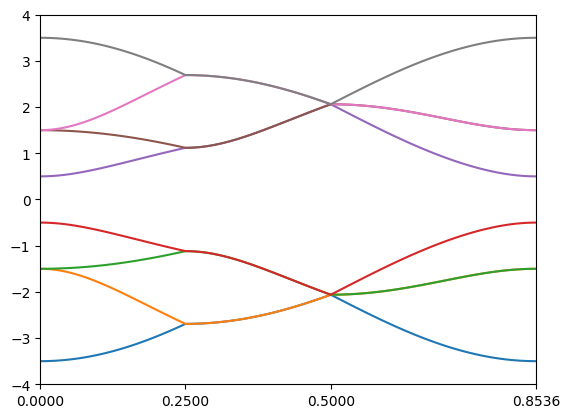

In [ ]:
#Before including disorder, compute the band structure of the supercell:
path=[[0.,0.],[0,.5],[.5,.5], [0.,0.]]
# labels of the nodes
label=(r'$\Gamma $',r'$M$', r'$K$', r'$\Gamma $')
(k_vec,k_dist,k_node)=sc_model.k_path(path,101,report=False)

# initialize figure with subplots
#fig, (ax1, ax2) = plt.subplots(1,2,figsize=(6.5,2.8))

# solve for eigenenergies of hamiltonian on
# the set of k-points from above
evals=sc_model.solve_all(k_vec)
# plot bands
plt.plot(k_dist,evals[0])
plt.plot(k_dist,evals[1])
plt.plot(k_dist,evals[2])
plt.plot(k_dist,evals[3])
plt.plot(k_dist,evals[4])
plt.plot(k_dist,evals[5])
plt.plot(k_dist,evals[6])
plt.plot(k_dist,evals[7])
plt.xticks(k_node)
#plt.xlabels(label)
plt.xlim(k_node[0],k_node[-1])
plt.ylim(-4,4)
plt.show()


In [ ]:
#Code to compute Chern number of disordered Chern Insulator, we will time the computation
import time


In [ ]:
PythTBTime=[]
for L in range(2,12,2):
    start_time = time.time()
    sc_model=ret_model.make_supercell([[int(L),0],[0,int(L)]],to_home=True)
    for j in range(sc_model.get_num_orbitals()):
        random_en=.5*2*(np.random.rand(1)-.5)[0]
        sc_model.set_onsite(onsite_en=random_en, ind_i=j, mode='add')
    my_array=wf_array(sc_model,[41,41])
    my_array.solve_on_grid([-0.5,-0.5])
    print(my_array.berry_flux(occ=range(int(L*L)), dirs=None, individual_phases=False)/(2*np.pi))
    print("--- %s seconds ---" % (time.time() - start_time))
    PythTBTime.append((time.time() - start_time))

In [ ]:
# Now lets compare with BerryEasy, first we define the model and plot the bandstructure

In [ ]:
#Define Matrices:
g_1 = np.array([[0,1],[1,0]])
g_2 = np.array([[0,-1j],[1j,0]])
g_3 = np.diag([1,-1])

U=-1.5*g_3
Tx=(-1j*g_1-g_3)/2
Ty=(-1j*g_2-g_3)/2
#Tz=(1j*g_3+g_5)/2
lat=pb.Lattice(a1=[1,0],a2=[0,1])
lat.add_sublattices(('A', [0,0],U))
lat.add_hoppings(
                 ([1,0], 'A', 'A', Tx),
                 ([0,1], 'A', 'A', Ty)
                )
lattice = lat

In [ ]:
#plt.rcParams["font.family"] = "Times New Roman"
#plt.rcParams.update({'font.size': 18})
model = pb.Model(lat,
           pb.primitive(a1=1,a2=1),
            pb.force_double_precision(),
            pb.translational_symmetry(a1=1, a2=1))
solver = pb.solver.lapack(model)

from math import pi
X = [pi,0,0]
Gamma = [0,0,0]
M= [pi,pi,0]

bands = solver.calc_bands( Gamma, X, M, Gamma,step=0.01)
bands.plot(point_labels=[ r'$\Gamma$', 'X', 'M', r'$\Gamma$'])
plt.ylabel(r'$E/t_{s}$')
plt.xlabel('')
plt.show()

In [ ]:
# Now lets create the supercell and evaluate the Chern number using a CPU

In [ ]:
BerryEasyCPUTime=[]
for L in range(2,12,2):
    start_time = time.time()
    L=int(L)
    model = pb.Model(lat,
                 pb.force_double_precision(),
                pb.primitive(L,L),
                pb.translational_symmetry(a1=L, a2=L))
    solver=pb.solver.lapack(model)
    positions=np.array(getattr(getattr(model, 'system'),'positions'))
    pot=[]
    for j in range(np.shape(positions)[1]):
        pot.append(.5*2*(np.random.rand(1)-.5)[0])
    def disorder():
        @pb.onsite_energy_modifier
        def potential(energy, x, y):
            v=0
            for i in range(np.shape(positions)[1]):
                xpos=positions[0][i]
                ypos=positions[1][i]
                v=v+pot[i]*(np.heaviside(-np.absolute(x-xpos),.5))*(np.heaviside(-np.absolute(y-ypos),0.5))
            return energy + v
        return potential
    model = pb.Model(lat,
        pb.primitive(L,L),
         disorder(),
        pb.force_double_precision(),
        pb.translational_symmetry(a1=L, a2=L))
    solver = pb.solver.lapack(model)
    plaquettes=40
    rvec1=2*np.pi/L
    rvec2=2*np.pi/L
    dsx=((np.pi/L)/(plaquettes))
    dsy=((np.pi/L)/(plaquettes))
    kp1=np.linspace(dsx,rvec1-dsx,plaquettes)
    kp2=np.linspace(dsy,rvec2-dsy,plaquettes)
    bnds=range(L*L)
    WCCtemp=[]
    for kx in kp1:
        for ky in kp2:
            kpts=np.array([[kx-dsx,ky-dsy,0],[kx+dsx,ky-dsy,0],[kx+dsx,ky+dsy,0],[kx-dsx,ky+dsy,0]])
            WCCtemp.append(be.WLine(kpts,model,bnds))
    chern=[]
    for j in range(np.shape(WCCtemp)[0]):
        chern.append(np.sum(WCCtemp[j]))
    print(np.sum(chern)/np.pi)
    print("--- %s seconds ---" % (time.time() - start_time))
    BerryEasyCPUTime.append((time.time() - start_time))

In [ ]:
# Using the CPU, PythTB and BerryEasy are comprable. Now let us consider using the GPU:

In [ ]:
#BerryEasyGPUTime=[]
for q in range(10,12,2):
    start_time = time.time()
    L=int(q)
    model = pb.Model(lat,
                pb.force_double_precision(),
              pb.primitive(L,L),
              pb.translational_symmetry(a1=L, a2=L))
    solver=pb.solver.lapack(model)
    positions=np.array(getattr(getattr(model, 'system'),'positions'))
    pot=[]
    for j in range(np.shape(positions)[1]):
        pot.append(.5*2*(np.random.rand(1)-.5)[0])
    def disorder():
        @pb.onsite_energy_modifier
        def potential(energy, x, y):
            v=0
            for i in range(np.shape(positions)[1]):
                xpos=positions[0][i]
                ypos=positions[1][i]
                v=v+pot[i]*(np.heaviside(-np.absolute(x-xpos),.5))*(np.heaviside(-np.absolute(y-ypos),0.5))
            return energy + v
        return potential
    model = pb.Model(lat,
      pb.primitive(L,L),
        disorder(),
      pb.force_double_precision(),
      pb.translational_symmetry(a1=L, a2=L))
    solver = pb.solver.lapack(model)
    plaquettes=40
    rvec1=2*np.pi/L
    rvec2=2*np.pi/L
    dsx=((np.pi/L)/(plaquettes))
    dsy=((np.pi/L)/(plaquettes))
    kp1=np.linspace(dsx,rvec1-dsx,plaquettes)
    kp2=np.linspace(dsy,rvec2-dsy,plaquettes)
    bnds=range(L*L)
    WCCtemp=[]
    for kx in kp1:
        for ky in kp2:
            kpts=np.array([[kx-dsx,ky-dsy,0],[kx+dsx,ky-dsy,0],[kx+dsx,ky+dsy,0],[kx-dsx,ky+dsy,0]])
            WCCtemp.append(begpu.WLine(kpts,model,bnds))
    chern=np.sum(np.sum(WCCtemp,2).flatten())
    #for j in range(np.shape(WCCtemp)[0]):
    #    chern.append(np.sum(WCCtemp[j]))
    print(np.sum(chern)/np.pi)
    print("--- %s seconds ---" % (time.time() - start_time))
    BerryEasyGPUTime.append((time.time() - start_time))

In [ ]:
#The GPU is significangtly faster